## Slice Sampling

In [1]:
import numpy as np
import numpy.random as npr
import pylab as plt
from slice_sample import slice_sample as my_slice_sample

In [2]:
# Spearmint version
def spearmint_slice_sample(init_x, logprob, sigma=1.0, step_out=True, max_steps_out=1000, 
                 compwise=False, verbose=False):
    """
    Copied from https://github.com/JasperSnoek/spearmint/spearmint/spearmint/util.py
    """
    def direction_slice(direction, init_x):
        def dir_logprob(z):
            return logprob(direction*z + init_x)
    
        upper = sigma*npr.rand()
        lower = upper - sigma
        llh_s = np.log(npr.rand()) + dir_logprob(0.0)
    
        l_steps_out = 0
        u_steps_out = 0
        if step_out:
            while dir_logprob(lower) > llh_s and l_steps_out < max_steps_out:
                l_steps_out += 1
                lower       -= sigma
            while dir_logprob(upper) > llh_s and u_steps_out < max_steps_out:
                u_steps_out += 1
                upper       += sigma
            
        steps_in = 0
        while True:
            steps_in += 1
            new_z     = (upper - lower)*npr.rand() + lower
            new_llh   = dir_logprob(new_z)
            if np.isnan(new_llh):
                print( new_z, direction*new_z + init_x, new_llh, llh_s, init_x, logprob(init_x))
                raise Exception("Slice sampler got a NaN")
            if new_llh > llh_s:
                break
            elif new_z < 0:
                lower = new_z
            elif new_z > 0:
                upper = new_z
            else:
                raise Exception("Slice sampler shrank to zero!")

        if verbose:
            print( "Steps Out:", l_steps_out, u_steps_out, " Steps In:", steps_in)

        return new_z*direction + init_x
    
    if not init_x.shape:
        init_x = np.array([init_x])

    dims = init_x.shape[0]
    if compwise:
        ordering = range(dims)
        npr.shuffle(ordering)
        cur_x = init_x.copy()
        for d in ordering:
            direction    = np.zeros((dims))
            direction[d] = 1.0
            cur_x = direction_slice(direction, cur_x)
        return cur_x
            
    else:
        direction = npr.randn(dims)
        direction = direction / np.sqrt(np.sum(direction**2))
        return direction_slice(direction, init_x)

In [3]:
def f(t):
    return t * np.sin(3*t) * np.exp(-t)
def f_2d(x):
    return (np.sin(1.5*x[0]/np.pi)**2 + np.cos(1.5*x[1]/np.pi)**2)

sd = 1
n_samples = 100

True


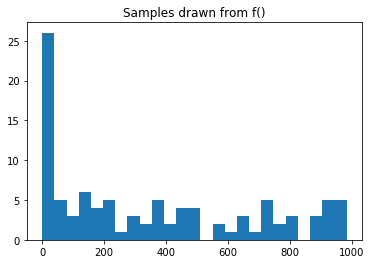

In [4]:
# 1D
np.random.seed(sd)
spearmint_samples = np.array([spearmint_slice_sample(np.array([1]), f) for _ in range(n_samples)])
np.random.seed(sd)
my_samples = np.array([my_slice_sample(np.array([1]), f) for _ in range(n_samples)])
print(np.allclose(spearmint_samples, my_samples))
_ = plt.hist(my_samples, bins=25)
plt.title("Samples drawn from f()")

In [5]:
# 2D
np.random.seed(sd)
spearmint_samples = np.array([spearmint_slice_sample(np.array([1, 1]), f_2d) for _ in range(n_samples)])
np.random.seed(sd)
my_samples = np.array([my_slice_sample(np.array([1, 1]), f_2d) for _ in range(n_samples)])
print(np.allclose(spearmint_samples, my_samples))

True


[]
[]


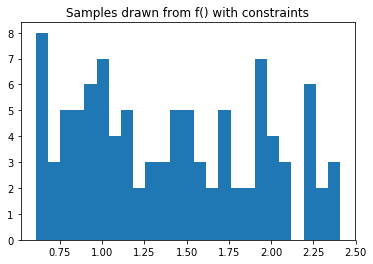

In [6]:
# now with the constraints
bounds = np.array([[0.6, 2.5]])
my_samples = np.array([my_slice_sample(np.array([1]), f, bounds=bounds) for _ in range(n_samples)])
_ = plt.hist(my_samples, bins=25)
plt.title("Samples drawn from f() with constraints")

# whether any samples lie outside the defined constraints
print(my_samples[my_samples<bounds[0,0]])
print(my_samples[my_samples>bounds[0,1]])